In [ ]:
#  Importations
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import joblib
import os

# 📥 Chargement du dataset
df = pd.read_csv("data/log_structured_labeled.csv")
df.dropna(inplace=True)
df = df[["Label", "Content"]]

# 🔤 Nettoyage et tokenisation
def preprocess(text):
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    return text.split()

df["tokens"] = df["Content"].apply(preprocess)
df.head()


,Label,Content,tokens
0,authentication-failed,[Tue Apr 11 14:36:11 2000] [error] [client 28....,"[tue, apr, error, client, user, jessicakaiser,..."
1,authentication-failed,[Tue Jan 21 17:01:07 2020] [error] [client 108...,"[tue, jan, error, client, user, mejianathan, a..."
2,authentication-failed,[Thu Oct 12 01:17:44 2023] [ malfunction error...,"[thu, oct, malfunction, error, client, user, a..."
3,authentication-failed,[Tue Jul 30 16:18:08 2013] [error] [client 217...,"[tue, jul, error, client, user, bushcassandra,..."
4,authentication-failed,[Thu Sep 10 05:09:58 2015] [error] [client 2.5...,"[thu, sep, error, client, user, dylanlewis, au..."


In [18]:
# 🧠 Entraînement du modèle Word2Vec (si non déjà fait)
w2v_model = Word2Vec(sentences=df["tokens"], vector_size=100, window=5, min_count=2, workers=4)
w2v_model.save("src/vectorizer.model")


In [19]:
# ➗ Vectorisation : moyenne des vecteurs de mots
def vectorize(tokens):
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X = np.array([vectorize(toks) for toks in df["tokens"]])

# 🎯 Encodage des labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Label"])

# Sauvegarde pour utilisation future
np.save("src/X.npy", X)
np.save("src/y.npy", y)


Taille du dataset : (34917, 3)
Distribution des labels :
 Label
http-request-failure            1167
ids-alert                       1167
network-traffic                 1167
file-read                       1167
file-modification               1167
file-deleted                    1167
file-action-failure             1167
directory-deleted               1167
directory-created               1167
directory-changed               1167
connection-opened               1167
connection-failed               1167
http-request-success            1167
process-started                 1166
process-shutdown                1166
process-error                   1166
system-configuration-changed    1166
authentication-failed           1166
hardware-monitoring             1166
user-session-open               1166
authentication-success          1165
process-info                    1165
database-operation              1165
connection-closed               1165
process-ended                   1164
user-logout

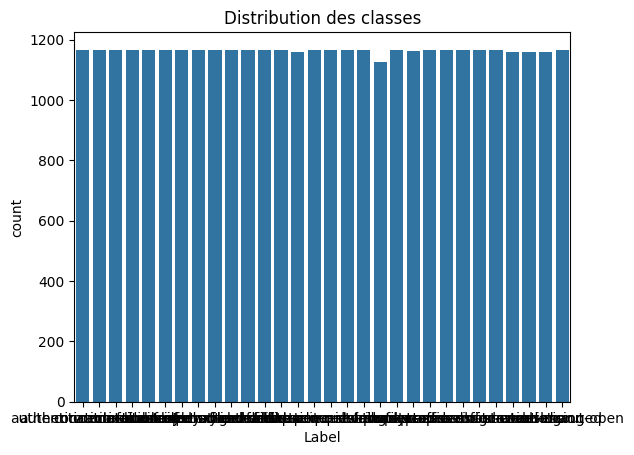

In [20]:
# 📈 Analyse statistique rapide
print("Taille du dataset :", df.shape)
print("Distribution des labels :\n", df["Label"].value_counts())

sns.countplot(x=df["Label"])
plt.title("Distribution des classes")
plt.show()


In [21]:
# ⚠️ Cas 1 : Sur-apprentissage
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)
clf_surfit = SVC(C=1000, kernel="linear")
clf_surfit.fit(X_train, y_train)

y_pred1 = clf_surfit.predict(X_test)

print("🔴 Surapprentissage :")
print("Accuracy:", accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

joblib.dump(clf_surfit, "src/model.pkl")


🔴 Surapprentissage :
Accuracy: 0.9356901928339592
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1044
           1       0.82      0.88      0.85      1040
           2       0.87      0.84      0.85      1064
           3       0.95      0.95      0.95      1060
           4       0.92      0.91      0.91      1045
           5       1.00      0.99      0.99      1041
           6       0.85      0.80      0.82      1053
           7       0.97      0.97      0.97      1050
           8       0.82      0.84      0.83      1052
           9       1.00      1.00      1.00      1038
          10       0.86      0.82      0.84      1050
          11       0.82      0.88      0.85      1038
          12       0.98      0.98      0.98      1075
          13       0.97      1.00      0.99      1046
          14       0.96      0.95      0.95      1052
          15       0.98      1.00      0.99      1044
          16       0.98      1.

['src/model.pkl']

In [22]:
# ✅ Cas 2 : Régularisation normale
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
clf_regul = SVC(C=1.0, kernel="linear")
clf_regul.fit(X_train, y_train)

y_pred2 = clf_regul.predict(X_test)

print("🟡 Régularisation :")
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

joblib.dump(clf_regul, "src/model_regul.pkl")


🟡 Régularisation :
Accuracy: 0.9573310423825888
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       227
           1       0.90      0.96      0.93       236
           2       0.89      0.94      0.91       253
           3       0.91      1.00      0.95       236
           4       0.97      0.89      0.93       244
           5       1.00      1.00      1.00       222
           6       1.00      0.73      0.84       232
           7       1.00      0.99      0.99       243
           8       0.79      0.99      0.88       228
           9       1.00      1.00      1.00       221
          10       0.98      0.76      0.86       248
          11       0.78      1.00      0.87       218
          12       0.99      1.00      0.99       259
          13       0.99      1.00      1.00       233
          14       0.99      0.99      0.99       219
          15       1.00      1.00      1.00       248
          16       1.00      1.00

['src/model_regul.pkl']

In [ ]:
# 🔁 Cas 3 : Validation croisée
clf_cv = SVC(C=0.5, kernel="linear")
scores = cross_val_score(clf_cv, X, y, cv=5, scoring="accuracy")

print("🟢 Validation croisée :")
print("Scores par pli :", scores)
print("Moyenne :", np.mean(scores))

clf_cv.fit(X, y)
joblib.dump(clf_cv, "src/model_cv.pkl")


🎯 Surappris - Accuracy : 0.9617640159512081
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       872
           1       0.92      0.92      0.92       878
           2       0.98      0.99      0.98       774
           3       0.94      0.97      0.96       886
           4       0.97      0.93      0.95       923
           5       0.84      0.83      0.84      1045
           6       0.99      1.00      1.00      1043
           7       0.85      0.86      0.86      1051
           8       1.00      1.00      1.00      1052
           9       0.86      0.87      0.86      1056
          10       0.83      0.84      0.84      1050
          11       1.00      1.00      1.00      1055
          12       1.00      1.00      1.00       696
          13       0.99      1.00      1.00       517
          14       1.00      1.00      1.00      1077
          15       1.00      1.00      1.00       988
          16       0.99      1.00    

In [24]:
# Comparaison globale
models = {
    "Surappris": clf_surfit,
    "Régularisé": clf_regul,
    "Validation croisée": clf_cv
}

for name, model in models.items():
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f" {name} - Accuracy: {acc:.4f}")
    print(classification_report(y, y_pred)) 


 Surappris - Accuracy: 0.9415
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1166
           1       0.84      0.89      0.86      1165
           2       0.88      0.85      0.87      1165
           3       0.96      0.96      0.96      1167
           4       0.93      0.92      0.92      1167
           5       1.00      0.99      0.99      1165
           6       0.86      0.81      0.84      1167
           7       0.97      0.98      0.97      1167
           8       0.83      0.86      0.85      1167
           9       1.00      1.00      1.00      1167
          10       0.88      0.84      0.86      1167
          11       0.83      0.89      0.86      1167
          12       0.98      0.98      0.98      1167
          13       0.98      1.00      0.99      1158
          14       0.96      0.95      0.96      1166
          15       0.98      1.00      0.99      1167
          16       0.98      1.00      0.99      11

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# 🔍 Matrice de confusion pour le meilleur modèle
best_model = clf_cv  # par exemple
y_pred = best_model.predict(X)

cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


🎯 Validation croisée - Accuracy scores : [0.65059817 0.85749472 0.86523575 0.86910626 0.65423192]
Moyenne : 0.7793333649514342
Écart-type : 0.10370218184332516


['src/model_cv.pkl']